<a href="https://colab.research.google.com/github/Adventurer8/In-context-RL-with-AD/blob/main/DarkRoom_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Отчёт**
По заданию на вакансию [Intern Research Scientist](https://shell-lillipilli-1d0.notion.site/Intern-Research-Scientist-1eb13525009b419bb93d5181bfe695e2#df4bc384f00a47e1b37186ce51b882c0)

# **Часть 1: Research**

## 1. Анализ статьи ([In-context RL with AD](https://arxiv.org/abs/2210.14215/))

Статья зацепила. Чем? - раскажу во второй части задания.

#### **1) Основные моменты статьи:**
- Недостатком PD является то, что результирующая политика не улучшается постепенно от дополнительного взаимодействия со средой (не может улучшить свою политику в контексте путем проб и ошибок). Методы PD учат политики, но не алгоритмы RL

- То есть, задача статьи - обучить трансформер **самой цели обучаться** (MetaRL), но за счет in-context

- Для этого необходимы данные, отражающие последовательный прогресс в обучении, что гипотетически позволит моделировать сам процесс обучения с подкреплением как задачу предсказания причинно-следственной связи.

- Трансформер должен быть способен включать в себе представление не только политики, но и **оператора улучшения политики**

- DarkRoom: Для обучения оптимальному алгоритму необходимы многоэпизодические контексты из 2-4 эпизодов в 50-150 шагов.



#### **2) Подумаем: Как из данных получить оператор?**

На абстрактном уровне данные истории обучения одной задаче $h^i$ содержат

$$ h^i = \left\{  {решение \choose задачи}^i + {улучшение \choose решения}^i +\ обучение\right\} = \left\{\widehat {P}^{\ i}+\widehat L^{\ i}+\widehat L\right\} $$

Так как оператор обучения более абстрактный/обобщенный, чем сами политики, то для его отделения/выделения нужно "диверсифицировать" представления политик в данных $H$:

$$ H = \sum_i h^i\ \ \Longleftrightarrow\ \ \ \bigcap_i h^i = \widehat L$$

Это сработает, если мы возьмем "линейно независимые" политики $\widehat {P}^{\ i}$, то есть л.н.з. задачи.

- В качестве среды возьмем *DarkRoom*
- В качестве модели RL возьмем самую простую *Q-Learning*

В DarkRoom необходимо найти goal, бродя в пустой комнате размером $N$x$N$, и в течение нескольких эпизодов оптимизировать свою траекторию. Алгоритм QL в процессе обучения такой задачи по сути создает векторное поле в виде Q-table, со стоком в точке goal. Это векторное поле в процессе обучения постепенно приходит к состоянию, когда оно становиться градиентом скалярного поля формы конуса (V) вокруг точки goal (короче, как потенциальная яма/ложбина). В такой интерпретации, получается, что трансформер должен научиться постепенно отягощать точку с предположительным goal на потенциальной в среднем ровной поверхности (с неоднородной кривизной как учетом стохастичности - механизма любопытства). Каждый $goal$^i$ можно считать разной/л.н.з. задачей.

Мы будем создавать истории $h^i$, включающие решение одной $i$-той задачи (start$\rightarrow$goal$^i$). Такие политики будут достаточно л.н.з., и чем больше разных goal мы возьмем, тем большую диверсификацию получим.

#### **3) Об операторе обучения**

> Политика RL улучшается на протяжении всей истории обучения. Поэтому, точное предсказание действий требует, чтобы модель AD не только выводила текущую политику из контекста, но и её улучшенные версии, таким образом выделяя оператор улучшения политики.

В нашей задаче оператор обучения $\widehat L$, по сути, превращается в оператор укорачивания траектории между фиксированными start$\rightarrow$finish, буквально до прямой. Поэтому, за критерий улучшения в нашей среде возьмем тенденцию в сокращении длинны успешных эпизодов.

На заметку:

> Под контекстным обучением понимается способность выводить задачи из контекста (например, LLM могут быть направлены на решение таких задач, как завершение текста, генерация кода и резюмирование, путем указания задачи в качестве подсказки). Эта способность - внутриконтекстное обучение.

Это значит, что возможно для "вызова" оператора может потребоваться некоторый катализатор/ключ/команда. Можно предположить, что после полного обучения трансформера для вызова оператора на тестой задаче необходимо будет скормить ему 1-4 успешных эпизода (или убедиться, что он справиться с первый эпизодом самостоятельно).


## 2. Код

### 1) Инициализация и основные фнукции

In [ ]:
# @title Скачиваем toymeta
!pip install toymeta    # Dark Room:  https://github.com/corl-team/toy-meta-gym/blob/main/src/toymeta/dark_room.py

In [ ]:
# @title Билиотеки  и выбор GPU
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
import torch.nn as nn
from collections import deque
from toymeta.dark_room import DarkRoom

import time
from tqdm import tqdm
import pygame;
from PIL import Image

# Определяем устройство: CPU или GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# @title Трансформер (GPT2)
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer

class GPT2Policy(nn.Module):
    def __init__(self, conf, action_dim, max_len=10):
        super(GPT2Policy, self).__init__()
        self.gpt2 = GPT2Model(conf)
        self.action_head = nn.Linear(conf.n_embd, action_dim)

    def forward(self, states):
        outputs = self.gpt2(states)[0]
        actions = self.action_head(outputs)
        return actions

In [ ]:
# @title Генерация данных алгоритмом Q-Learning
# Генерирует последовательность историй достижения агентом статического финиша из статического старта
# Точка финиша и Старта изначально генерируется случайным образом
# Метод: Q-Learning
# Возвращает последовательность историй, история - последовательность состояний (state, action, reward)

def generate_bandit_data(env, num_episodes, state_dim, action_dim, max_steps, best_story=False, pr=False):
    stories = []

    # Q-Learning
    # Параметры обучения
    # Можно попробовать брать случайные параметры как пример ~разных политик
    alpha = 0.1      # Скорость обучения
    gamma = 0.9      # Дисконтирующий фактор
    epsilon = 1.0    # Начальное значение epsilon для epsilon-greedy
    epsilon_decay = 0.995   # Темп снижения epsilon
    epsilon_min = 0.2       # Минимальное значение epsilon

    total_steps = 0

    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        story = []
        step = 0
        best_step_flag = False
        total_reward = 0
        start = state
        finish = env.pos_to_state(env.goal_pos)

        for step in range(max_steps):
            # Выбор action с использованием epsilon-greedy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Выбираем случайное действие
            else:
                action = np.argmax(q_table[state])  # Выбираем действие с максимальным Q-значением

            next_state, reward, terminated, truncated, _ = env.step(action)

            # Отладка: Для проверки на копирование трансформером политики
            # if episode > 0.8*num_episodes:
            #     story.append((state, action, reward))

            story.append((state, action, reward))
            total_reward += reward

            # Обновление Q-таблицы
            best_next_action = np.argmax(q_table[next_state])
            q_table[state, action] += alpha * (reward + gamma * q_table[next_state, best_next_action] - q_table[state, action])

            state = next_state

            if not best_step_flag:
                if reward > 0:
                    best_step_flag = step

            if terminated:
                break

            # Что если заканчивать эпизод при определенном total reward?
            # Чтобы научить модель стоять при достижении цели
            # if total_reward > max_steps/3:
            #     break

        # Снижение epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        if best_story:
            if total_reward > 0: # or if done? (it's intereting)
                stories.append(story)
        else:
            stories.append(story)
        if pr:
            print(f"Episode {episode+1:3}/{num_episodes:03d} completed in {best_step_flag:3}/{step+1:03d} steps, reward {total_reward:4}, task ({start:2}->{state:2}/{finish})")
        total_steps+= int(best_step_flag)
    print(f"=== Episodes {len(stories):3}/{num_episodes:2} completed in {total_steps} total steps")
    return stories

In [ ]:
# @title Токенизация и Обучение

# Токенизация данных
# Вижу два варианта токенизировать:
# [+] В тройки токенов (s, a, r)
# [-] В один токен, соответствующий уникальной тройке (например, r*1 + a*10 + s*100)

# Функции для преобразования состояний, действий и вознаграждений в токены
def tokenize_three(three):
    tokens = []
    state, action, reward = three
    tokens.append(action_dim + state)  # Смещаем действия
    tokens.append(action)  # Предполагается, что action уже является токеном: небольшая хитрость, чтобы не декодировать его при подсчете loss
    tokens.append(state_dim + action_dim + int(reward))  # Cмещаем вознаграждения
    return tokens

def tokenize_end():
    eos_token = config.vocab_size - 1
    return [eos_token, 0, eos_token]

def tokenize_sequence(sequences):
    tokens = []
    for sequence in sequences:
        for three in sequence:
            tokens.extend(tokenize_three(three))
        tokens.extend(tokenize_end())  # Добавляем токен конца последовательности
    return tokens

# Функция подготовки данных для обучения
# Делим последовательность последовательностей на случайные чанки в количестве*(chunk_freq)
# И возвращаем массив из индексов начал чанков
def generate_chunks_num(tokens, chunk_size, chunk_freq=1):
    # Разбиваем на chunks длиной max_len
    # Причем не важно - начало это эпизода или где ещё
    chunks = []
    num_chunks = ((len(tokens)//3) // chunk_size)  # Число чанков
    for i in range(num_chunks * chunk_freq):
        rand = random.randint(0, len(tokens) - chunk_size*3)
        rand-= rand % 3         # х3 - потому что tokens хранит state-action-reward
        chunks.append(rand)
    return chunks

# Обучение
def train_model(model, data, chunk_size, epochs=10, chunk_freq=1, lr=1e-4):
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_data = []

    # Подготовка данных
    tokens = tokenize_sequence(data)
    chunks = generate_chunks_num(tokens, chunk_size, chunk_freq)  # Индексы начала чанков

    for epoch in range(epochs):
        total_loss = 0

        for chunk in tqdm(chunks):
            # Преобразование чанка в тензор
            batch = torch.tensor(tokens[chunk:chunk+chunk_size*3], dtype=torch.long).unsqueeze(0).to(device)

            # Разделение входных данных и целевых action
            inputs = batch[:, :-2]  # Все кроме последних action-reward
            targets = batch[:, 1::3]  # Все action

            optimizer.zero_grad()
            logits = model(inputs).squeeze(0)

            # Преобразование логитов и целевых action к нужной форме
            logits = logits[0::3,:]  # Отбираем только логиты предсказанных action (на местах входных state)
            logits = logits.view(-1, logits.size(-1))
            target_actions = targets.view(-1).to(device)

            loss = criterion(logits, target_actions)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loss_data.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {total_loss}')

    # Построение графика потерь
    plt.figure(figsize=(10, 5))
    plt.plot(loss_data, label='Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Batches')
    plt.legend()
    plt.show()

### 2) Экспериментальная установка

In [ ]:
### Инициализация параметров
env_size = 9              # Размер среды DarkRoom
state_dim = env_size**2   # Размер пространства состояний среды (9x9)
action_dim = 5            # Размер пространства дейтсвий

num_stories = 25          # Количество разных задач (разных = случайных начальных условий)
num_episodes = 120        # Количество последовательных эпизодов в обучении одной задаче (длина истории)
max_steps = 100           # Предел по количеству шагов в одном эпизоде (чтобы отбрасывать слишком долгие эпизоды)
terminate_on_goal = True  # Заканчивать эпизод по достижению цели
best_story = True         # Брать ли только оконченные эпизоды? (terminated on goal)
random_start = True       # Случайные начальные координаты

trajectory_print = False   # Вывод генерированных траекторий



### Генерация историй
# Формат
# [-] Одна история из последовательности попыток: [(o1,a1,r1), ..., (og,ag,rg), /достиг goal -> вернулся в начало/ , (o1,a1,r1), .../-> достиг оптимальной политики/]
# [-] Или каждая попытка по отдельности:  [[(oar)1, ... (oar)g], .../достиг оптимальной политики по задаче/, [(oar),...], /история следующих агентов-задач/...]
# [+] Всё в одну длинную последовательность. При токенизации добавлять токен конца последовательности


# Создаем истории обучения нескольких агентов (с разными координатами цели)
data = []
goal = None   # Случайные

for agent in range(num_stories):
    # Обновляем среду (координаты финиша). Каждый агент - разная задача
    env = DarkRoom(size=env_size, goal=goal, random_start=random_start, terminate_on_goal=terminate_on_goal, render_mode="rgb_array")
    state, _ = env.reset()
    finish = env.pos_to_state(env.goal_pos)

    # Генерация последовательностей эпизодов одной задачи
    print(f'--- Agent {agent} start task ({state if not random_start else "R"}->{finish}) ---')
    data.extend(generate_bandit_data(env, num_episodes, state_dim, action_dim, max_steps, best_story=best_story, pr=trajectory_print))


--- Agent 0 start task (R->42) ---
=== Episodes 104/120 completed in 2259 total steps
--- Agent 1 start task (R->43) ---
=== Episodes 106/120 completed in 2606 total steps
--- Agent 2 start task (R->26) ---
=== Episodes  90/120 completed in 2191 total steps
--- Agent 3 start task (R->4) ---
=== Episodes 106/120 completed in 2860 total steps
--- Agent 4 start task (R->11) ---
=== Episodes  97/120 completed in 2567 total steps
--- Agent 5 start task (R->26) ---
=== Episodes  93/120 completed in 2545 total steps
--- Agent 6 start task (R->25) ---
=== Episodes  82/120 completed in 1833 total steps
--- Agent 7 start task (R->34) ---
=== Episodes  95/120 completed in 1960 total steps
--- Agent 8 start task (R->28) ---
=== Episodes  91/120 completed in 1936 total steps
--- Agent 9 start task (R->14) ---
=== Episodes  98/120 completed in 2262 total steps
--- Agent 10 start task (R->57) ---
=== Episodes  97/120 completed in 1922 total steps
--- Agent 11 start task (R->57) ---
=== Episodes  99/1

Training in 20 epoch:


100%|██████████| 1632/1632 [00:24<00:00, 67.23it/s]


Epoch 1, Loss: 1540.361756503582


100%|██████████| 1632/1632 [00:23<00:00, 68.16it/s]


Epoch 2, Loss: 1493.6606643795967


100%|██████████| 1632/1632 [00:23<00:00, 69.17it/s]


Epoch 3, Loss: 1464.5096015930176


100%|██████████| 1632/1632 [00:23<00:00, 68.21it/s]


Epoch 4, Loss: 1442.9533557891846


100%|██████████| 1632/1632 [00:24<00:00, 67.67it/s]


Epoch 5, Loss: 1422.3262394070625


100%|██████████| 1632/1632 [00:23<00:00, 68.69it/s]


Epoch 6, Loss: 1403.6427756547928


100%|██████████| 1632/1632 [00:23<00:00, 69.50it/s]


Epoch 7, Loss: 1388.6887826919556


100%|██████████| 1632/1632 [00:23<00:00, 69.26it/s]


Epoch 8, Loss: 1374.5465506315231


100%|██████████| 1632/1632 [00:23<00:00, 68.57it/s]


Epoch 9, Loss: 1358.3137737512589


100%|██████████| 1632/1632 [00:23<00:00, 68.61it/s]


Epoch 10, Loss: 1344.5930551290512


100%|██████████| 1632/1632 [00:23<00:00, 68.79it/s]


Epoch 11, Loss: 1334.112991988659


100%|██████████| 1632/1632 [00:23<00:00, 68.69it/s]


Epoch 12, Loss: 1323.5305507183075


100%|██████████| 1632/1632 [00:23<00:00, 68.67it/s]


Epoch 13, Loss: 1311.282988190651


100%|██████████| 1632/1632 [00:23<00:00, 69.05it/s]


Epoch 14, Loss: 1299.4740231633186


100%|██████████| 1632/1632 [00:23<00:00, 68.71it/s]


Epoch 15, Loss: 1289.5823682546616


100%|██████████| 1632/1632 [00:23<00:00, 68.91it/s]


Epoch 16, Loss: 1278.4153343439102


100%|██████████| 1632/1632 [00:23<00:00, 68.74it/s]


Epoch 17, Loss: 1269.2364801764488


100%|██████████| 1632/1632 [00:23<00:00, 69.09it/s]


Epoch 18, Loss: 1258.7828060388565


100%|██████████| 1632/1632 [00:23<00:00, 69.25it/s]


Epoch 19, Loss: 1251.1116491556168


100%|██████████| 1632/1632 [00:23<00:00, 69.24it/s]


Epoch 20, Loss: 1242.373454451561


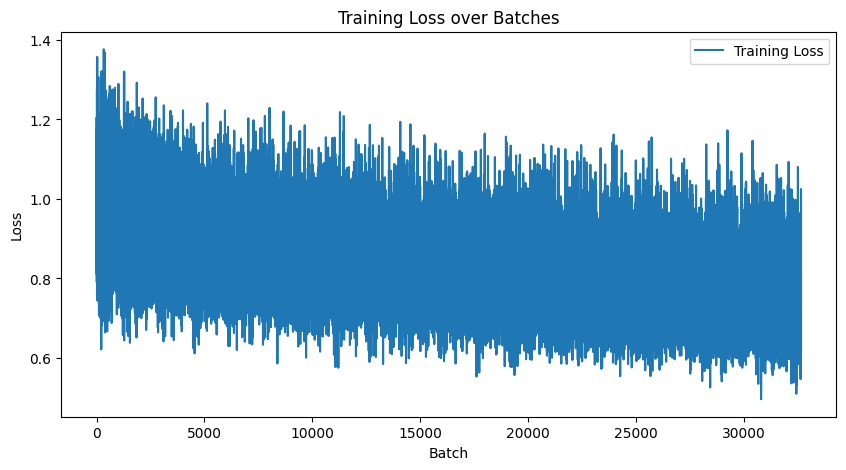

In [ ]:
### Алгоритм дистилляции

histories_size = 30            # Длина эпизодичности контекстов обучения
                               # Однако, эпизоды разной длины, поэтому чанк охватывает
chunk_size = histories_size * max_steps//8   # Средняя длинна эпизода меньше (~в 6-8 раз)

# Правильнее было бы хранить эпизоды по отдельности
# и только потом превращать в чанки нужной эпизодичности и токены

chunk_freq = 8   # Количество случайных чанков в отношении к общей вместительности из таких чанков
context_size = 3 * chunk_size

epoch = 20

# Инициализация модели GPT-2
config = GPT2Config(
    vocab_size=128,     # Примерно 128 > num_state + num_action + num_reward
    max_position_embeddings=context_size,
    n_positions=context_size,
    n_ctx=context_size,
    n_embd=256,
    n_layer=5,
    n_head=4,
    n_inner=256,
    resid_pdrop=0.1,         # Dropout rate для residuus соединений
    attn_pdrop=0.5,          # Dropout rate для механизма внимания
    embd_pdrop=0.1,          # Dropout для эмбеддингов
    layer_norm_epsilon=1e-5, # Epsilon для LayerNorm
    initializer_range=0.02,  # Начальный диапазон для весов
    use_cache=True,          # Использовать кэширование
    position_embedding_type="relative_key_query", # Относительные позиционные эмбеддинги для ключей и запросов
                                                  # Позволяет модели учитывать и ключевые моменты в последовательности, и их взаимосвязь
)

# model = GPT2Policy(config, action_dim)

# Обучение модели
print(f'Training in {epoch} epoch:')
train_model(model, data, chunk_size, epoch, chunk_freq)


### 3) Тестирование

In [ ]:
# @title Функция тестирования
# Тестирование

def render_environment(env):
    # Отображаем текущее состояние среды
    frame = env.render()

    # Проверяем, если состояние является изображением
    if frame.ndim == 3 and frame.shape[2] == 3:
        frame = np.transpose(frame, (1, 0, 2))  # Транспонируем изображение, если необходимо
        return pygame.surfarray.make_surface(frame)
    else:
        raise ValueError("Неверный формат изображения. Проверьте метод render()")



# Тест с Визуализацией
# gif_episode = False or num_frame - делать гифку кажыде n эпизодов
# story       = предыстория обучения
# best_story  = True - отбирать только истрии с reward > 0

def test(model, env, num_episodes=20, max_steps=100, gif_episode=False, story = [], best_story=False):

    gif_flag = False
    if gif_episode:
        pygame.init()
        window_size = 600  # Установите размер окна
        screen = pygame.display.set_mode((window_size, window_size))
        clock = pygame.time.Clock()

    # Переносим на GPU
    model.to(device)

    for episode in range(num_episodes):
        state, _ = env.reset()
        action = 0
        reward = 0.0
        story.extend(tokenize_three([state, action, reward]))
        done = False
        step = 0
        total_reward = 0

        if gif_episode:
            if episode % gif_episode == 0:
                gif_text = f'Ep{episode+1} GIF saved!'
                frames = []
                gif_flag = True
        if not gif_flag:
            gif_text = ''

        for step in range(max_steps):
            # Выбираем лучшее действие
            input_tensor = torch.tensor(story, dtype=torch.long).unsqueeze(0).to(device)
            logits = model(input_tensor)
            action = torch.argmax(logits[0][-2], dim=-1).item()  # Берем только last action из под state-action-reward

            # Выполняем шаг
            next_state, reward, terminated, _, _ = env.step(action)
            total_reward += reward

            if gif_flag:
                # Рендерим текущее состояние среды
                frame = render_environment(env)

                # Масштабируем изображение до размера окна
                frame = pygame.transform.scale(frame, (window_size, window_size))

                # Отображаем кадр
                screen.blit(frame, (0, 0))
                pygame.display.flip()

                # Добавляем кадр в список
                frame_data = pygame.surfarray.array3d(frame)
                frame_data = np.transpose(frame_data, (1, 0, 2))  # Приведение к правильному формату
                frames.append(Image.fromarray(frame_data))

                # Пауза между кадрами
                # clock.tick(20)  # 20 FPS

            if best_story:
                if total_reward > 0.0:
                    story.extend(tokenize_three([state, action, reward]))
                    # print('круто, записал >')
            else:
                story.extend(tokenize_three([state, action, reward]))
                # print('записал >')
            if len(story) > context_size*3:
                story = story[-context_size*3:]

            state = next_state

            if terminated:
                break
        story.extend(tokenize_end())


        print(f'Episode {episode+1:2}/{num_episodes}, Steps: {step:2}, Reward: {total_reward:4}, ' + gif_text)

        if gif_flag:
            # Сохранение GIF
            gif_filename = f"episode_{episode+1:03d}.gif"
            frames[0].save(gif_filename, save_all=True, append_images=frames[1:], optimize=False, duration=100, loop=0)

    if gif_episode:
        print('GIF\'s saved!')
        pygame.quit()

    env.close()


Заранее скажу, что по результатам In-Context наблюдать не смог. Анализ в выводах.

In [ ]:
# Настроки для тестов
num_episodes = 100
max_steps = 200
goal = None
# goal = (8,6)
best_story = True     # Сохранять в историю (контекст) только успешные эпизоды
gif_episode = False    # Создавать гиф на каждый эпизод

In [ ]:
# Тест новой задачи
env = DarkRoom(size=9, goal=goal, random_start=random_start, terminate_on_goal=terminate_on_goal, render_mode="rgb_array")  # Обновились координаты goal

test(model, env, num_episodes, max_steps, gif_episode, story=[], best_story=best_story)

Если долго не может найти цель, попробуем первую историю генерировать как показательную:

К сожалению, у следующего кода под самый конец моих экспериментов (под кульминацию) появилась ошибка связанная с девайсом CUDA, которая ломает весь колаб. Разобраться и исправить, увы, не успел.

In [ ]:
# Тест новой задачи
# с предыстрией начинающего успешного агента😎

env = DarkRoom(size=9, goal=goal, random_start=random_start, terminate_on_goal=terminate_on_goal, render_mode="rgb_array")  # Обновились координаты goal

pre_episodes = 20     # Количество эпизодов успешного агента
pre_steps = max_steps # Число последних шагов успещного агента, из которых состоит предыстория
prestory = generate_bandit_data(env, pre_episodes, state_dim, action_dim, max_steps, best_story, pr=True)[-max_steps:]

test(model, env, num_episodes, max_steps, gif_episode, story=tokenize_sequence(prestory), best_story=best_story)


## 3. Выводы

### Почему не полулось обнаружить In-Context
1) Мало эпох обучения
- ближе к дедлайну стал дольше обучать (эпох 30-40), видеть прогресс модели, но доэксперименировать не удалось

2) Мало данных
- увеличивал до 100 историй по 100 эпизодов
- можно увеличить число задач до 100 случайных
(максимум есть 81 одна разная задача)

3) Не верно организованы батчи

- батчи имеют неизвестное число эпизодов (но строгий размер)
- батчи начинаются со случайного токена
- батчи объединяют последовательность разных историй

4) Не верные гиперпараметры и модель
- длина батчей ~ количество эпизодов не отражают "обучение"
- сама модель трансформера неудачная (число слоев, голов, эмбэдингов, архитектура...)

5) Плохо подаются данные
- не различает 3 модальности
- возможно стоит по другому токенизировать
- или использовать архитектуру с мультимодальностью

6) Сами обучающие данные плохо отражают обучение
- возможно QL не качественно отражает обучение методом проб и ошибок

7) Тестирование
- Возможно трансформеру не хватает катализатора/ключа/команды, чтобы вызвать оператор "обучения". Решение - давать ему начало (3-4 эпизода) из успешной истории



## 4. Идеи и Гипотезы

Если принять интерпретацию работы нейросетей и, в частности, трансформеров:
- каждый новый слой имеет в своем эмбэдинге более абстрактные и общие представления.

Что если сначала обучать модель самим эпизодам, и оптимизировать её до представлений эпизода (начало и конец с наградой, токен конца эпизода, понимание "стенок", простые шаблоны движения, любопытсво (стохастичность)). То есть, научить её фантазировать развитие эпизода вплоть до `reward=1`. И только после обучения всем базовым ("приземленным") представлениям, начать давать ей целые истории, чтобы она начала искать более абстрактные/общие представления, эпизодическую связь, в поисках того самого "оператора обучения".

Поэкспериментировать с этой гипотезой не успел.

# **Часть 2: Scientist**

**Задание:**
Расскажите о трех статьях с A* конференций по RL, которые зацепили вас больше всего за последние пару лет...

Я аспирант и выбрал специальность [5.12.4. Когнитивное моделировани](https://vak.minobrnauki.gov.ru/uploader/loader?type=17&name=92259542002&f=15363) (п.1/8/11/12), и мой интерес обобщается созданием когнитивного ИИ.

Иначе говоря, мне интересны в первую очередь именно теоретические модели человеческого разума (или живых существ), и уже на основе этих представлений и моделей формализовать программные модели ИИ.

По этому, последний год мне были интересны более абстрактные статьи, которые дают мне общую картину и пространство для идей, которые позволяют лучше интерпретировать собственное мышление и проецировать на современные модели нейросетей, чтобы уже на основе этого понимания формализовать новые когнивтиные карты и модели разума/ИИ.

Пример теоретических:
- [Байесовская модель](https://royalsocietypublishing.org/doi/pdf/10.1098/rsfs.2022.0029) мозга
  - Описывает мозг как пространство убеждений, которые обновляются в процессе получения новой информации (связанной с "неожиданностью" - отличием информации от предсказываемой убеждениями)
- Принципы [теории разума](https://www.frontiersin.org/journals/systems-neuroscience/articles/10.3389/fnsys.2016.00084/full)
  - Описывает знания человека в виде метапространства концепций ("паутины" отношений объектов, явлений и идей), концеции в которой имеют когнитивную иерархию: от "приземленных" представлений объектов и явлений до абстрактных представлений идей (тут можно вспомнить обобщающую способность тех же трансформеров, или автоэнкодеров), которые проявляются как нисходящие и восходящие сигналы в биологических НС.
- Модель двойного процесса
  - Мозг действует в двух "режимах": Система 1, выполняющая уже известные обученные операции быстро и бессознательно (как готовая обученная нейросеть), и Система 2, выделяющая внимание при встрече с "неожиданностью" для сознательных умственных усиличий по обновлению "предсказательной машины" (обновлению убеждений)
- [Принцип свободной энергии](https://www.sciencedirect.com/science/article/pii/S1571064517301409)
  - Он гласит о том, что живые существа, как самоорганизующиеся системы, стремятся к поглощению информации из окружающей среды (негэнтропии) для увеличения собственной упорядоченности, самосохранения. Если углубляться, этот принцип по сути описывает RL, но характеризует причины появления живых систем и "разума" через естественный отбор и фундаментальные физические принципы.
- И другие модели из когнитивных наук (тоже "внимание").


Если говорить про более прикладныее RL статьи, самой яркой вспомнил:
- [Модель мира](https://arxiv.org/abs/2301.04104) (и аналогичные статьи)
  - сама идея вдохновлена человеческим мышлением - способностью моделировать мир в воображении, заранее делать предсказания последствий каких-либо действий, и постепенно обучаться на все том же методе проб и ошибок, но уже обновляя механизмы модели мира (познание мира). Это сильно позволяет ускорять обучение, и цепляет это по двум причинам:
    - как минимум, каждый любитель точных наук пользуется такой способностью
    - потому что, такой метод позволяет быстрее обучаться, дел
    - нейросеть это универсальная функция, которую можно по шажочкам оптимизировать до искомой. Функция это практически тоже самое что и модель. Значит, любое представление объектов и явлений мира явлется моделью, ну или субмоделью в общей модели мира. Поэтому, как и человека, такую нейросеть теоретически можно медленно обучать субмоделям (объектам, явлениям, действиям), собирая целую картину. Но следствие, которое сводит меня с ума в этой идее, что представление в модели мира самого себя (того кто воспроизводит эту модель) является той рефлексией порождающей самосознание в разумных существах.
    - и это по сути снова отражает принцип свободной энергии, упомянутый ранее: живые системы поглащают информацию об окружающем мире (делая его для себя предсказуемым), для того чтобы адаптироваться (сохранить собственную упорядоченность, ну то есть выжить). А значит любой RL алгоритм универсально стремиться выстроить как можно более подробную модель мира (или ограниченно - модель окружающей его среды, словно обучение сходится к отражению)
    - а ещё очень цепляет применение таких алгоритмов на симмуляторах-песочницах с открытым миром по типу MineCraft

Меня также зацепила одна идея, на основе статьи к этому заданию ([In-context RL with AD](https://arxiv.org/abs/2210.14215/)):
- факт того, что нейросеть обучилась "оператор"

Другими словами, нейросеть научилась какому-то действию. И ведь если задуматься, большинство действий можно представить в виде инструкций из простых базовых действий, команд (субфункций). GPT научился этим базовым действиям работы с текстом, но, имея некоторую модель мира, он также научился моделировать более "реальные" действия в виде текстовых последовательностей.

Из этой мысли появляется много интересных общих идей:
- Можно ли у GPT развить модель мира?
- Можно рекурсивно замкнуть GPT с промтом создания новых действий на основе старых?
- Получается, глубокие сети имеют способность хранить не только "знания", но и операторы (действия, с конкретной целью). Это спускает концепции "знаний", как вывода нейросети, с действиями. То есть, часть выходных токенов нейросети можно напрямую подключать к действиям, а часть оставлять как новое знание (мысль) и возвращать на вход. Ну эта идея у меня уже связана непосредственно с тем, что я путаюсь реализовать в своей диссертации.



Тематикой своей диссертации я выбрал: "Моделирование рефлексивного мышления искусственных агентов в обучении с подкреплением". Этим летом начал продумывать методы эксперимента, и чувствую, что направление исследований Вашей команды (Адаптивные агенты) очень перспективно взаимосвязано с моей темой. Поэтому хотелось бы пообщаться на эту тему как ученые и помочь друг другу в реализации идей.

